In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Mounted at /content/gdrive


In [3]:
import pandas as pd
import os
import glob
from tqdm.auto import tqdm

In [4]:
MONTH = ['Aug_2020', 'Sep_2020', "Oct_2020", 'Nov_2020', 'Dec_2020'] 

DIR = '/content/gdrive/MyDrive/Colab/COMS6998EMODS/Hyderated_Tweets_Hate_Indicator/'

merged_df = []
for month in MONTH:

  month_dir = DIR + month + "/*"
  files = glob.glob(month_dir)

  files = sorted(files)
  #files = files[:1]
  print(month)
  for file in tqdm(files):
    df = pd.read_csv(file, sep=',', engine='python')
    df = df[df['score'] >= 0.1]
    merged_df.append(df)

data = pd.concat(merged_df)

Aug_2020


  0%|          | 0/31 [00:00<?, ?it/s]

Sep_2020


  0%|          | 0/30 [00:00<?, ?it/s]

Oct_2020


  0%|          | 0/31 [00:00<?, ?it/s]

Nov_2020


  0%|          | 0/30 [00:00<?, ?it/s]

Dec_2020


  0%|          | 0/31 [00:00<?, ?it/s]

In [5]:
print(data.columns)
# data = data.drop(['withheld_in_countries', 'withheld_scope', 'withheld_copyright'], axis=1)
data

Index(['id', 'full_text', 'user', 'place', 'state', 'score',
       'withheld_in_countries', 'withheld_scope', 'withheld_copyright'],
      dtype='object')


,id,full_text,user,place,state,score,withheld_in_countries,withheld_scope,withheld_copyright
10,1289411993120542720,Here’s an idea... STAY THE FUCK HOME https://t...,"{'id': 77883678, 'id_str': '77883678', 'name':...","{'id': '300bcc6e23a88361', 'url': 'https://api...",WA,0.988251,NaN,NaN,NaN
16,1289412432755007488,All of them gotta go after we get reparations ...,"{'id': 1051473635926568960, 'id_str': '1051473...","{'id': '2af60542479207ed', 'url': 'https://api...",MD,0.398334,NaN,NaN,NaN
23,1289412825002074115,@JenRodbowers @yestradamous @ThinkingTiny @Ros...,"{'id': 867486782035599360, 'id_str': '86748678...","{'id': 'bd3d2074a33fbd06', 'url': 'https://api...",OK,0.235811,NaN,NaN,NaN
30,1289413114681683970,“He Means Not What He Says” The @GOP sheep cre...,"{'id': 21303710, 'id_str': '21303710', 'name':...","{'id': '3b77caf94bfc81fe', 'url': 'https://api...",CA,0.360563,NaN,NaN,NaN
102,1289419126008553472,Send this babe some seeds in the mail. https:/...,"{'id': 161417898, 'id_str': '161417898', 'name...","{'id': '0b93bc6a33455615', 'url': 'https://api...",CA,0.818494,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2663,1344864330991480835,They should be CHARGED with DESTRUCTION of PRO...,"{'id': 954929399379480576, 'id_str': '95492939...","{'id': '1316eee69a639480', 'url': 'https://api...",MO,0.187088,NaN,NaN,NaN
2677,1344867890927951872,Sending 💘 to you &amp; your wife https://t.co/...,"{'id': 4315629553, 'id_str': '4315629553', 'na...","{'id': '044f809bcfa0fb4b', 'url': 'https://api...",IL,0.917085,NaN,NaN,NaN
2693,1344871298866896897,GOP hate the American people but love the rich...,"{'id': 1061109464391184384, 'id_str': '1061109...","{'id': '7714f2c70ed66321', 'url': 'https://api...",CT,0.341588,NaN,NaN,NaN
2696,1344864565885022210,And I’m sure no one believes this. We’re fucke...,"{'id': 1715768911, 'id_str': '1715768911', 'na...","{'id': '9807c5c5f7a2c6ce', 'url': 'https://api...",MN,0.145824,NaN,NaN,NaN


In [ ]:
!pip install  pysentimiento 

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from pysentimiento.preprocessing import preprocess_tweet

import nltk
nltk.download('wordnet')

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

text = []
for index, row in data.iterrows():
  full_text = row['full_text']
  text.append(preprocess_tweet(full_text))

text_data = pd.DataFrame(text, columns=['full_text'])
text_data

,full_text
0,Heres an idea... STAY THE FUCK HOME url
1,All of them gotta go after we get reparations url
2,@usuario @usuario @usuario @usuario @usuario F...
3,"""He Means Not What He Says"" The @usuario sheep..."
4,Send this babe some seeds in the mail. url
...,...
40574,They should be CHARGED with DESTRUCTION of PRO...
40575,Sending emoji corazón con flecha emoji to yo...
40576,GOP hate the American people but love the rich...
40577,And Im sure no one believes this. Were fucked!...


In [141]:
from sklearn.feature_extraction import text

stop_word = text.ENGLISH_STOP_WORDS.union(['emoji', 'just', 'dont', 'amp', 'usuario', 'like', 'need', 'let', 'don'])

vect = CountVectorizer(min_df=20, max_df=0.1, stop_words=stop_word, 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')

# Fit and transform
X = vect.fit_transform(text_data.full_text)
 
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
 
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
 
 
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
 
ldamodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id_map, passes=2, random_state=5, num_topics=6, workers=4)

for idx, topic in ldamodel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.010*"country" + 0.010*"mask" + 0.009*"want" + 0.009*"home" + 0.009*"die" + 0.008*"stay" + 0.008*"state" + 0.008*"government" + 0.007*"wear" + 0.007*"stop"


Topic: 1 
Words: 0.022*"cara" + 0.011*"going" + 0.008*"white" + 0.006*"lies" + 0.006*"die" + 0.005*"american" + 0.005*"virus" + 0.005*"america" + 0.005*"shut" + 0.005*"ojos"


Topic: 2 
Words: 0.047*"vote" + 0.032*"america" + 0.022*"biden" + 0.013*"save" + 0.013*"blue" + 0.009*"tono" + 0.009*"piel" + 0.008*"harris" + 0.008*"harris2020" + 0.008*"end"


Topic: 3 
Words: 0.007*"mask" + 0.007*"fuck" + 0.007*"bitch" + 0.007*"away" + 0.007*"stop" + 0.006*"country" + 0.006*"real" + 0.006*"did" + 0.006*"killing" + 0.006*"vaccine"


Topic: 4 
Words: 0.014*"biden" + 0.013*"china" + 0.011*"vote" + 0.010*"president" + 0.008*"virus" + 0.007*"america" + 0.006*"money" + 0.006*"does" + 0.006*"pandemic" + 0.006*"right"


Topic: 5 
Words: 0.016*"000" + 0.010*"cara" + 0.010*"dead" + 0.009*"country" + 0.008*"pandemic" + 0.008*"ameri

In [143]:
def topic_distribution(string_input):
    string_input = [string_input]
    # Fit and transform
    X = vect.transform(string_input)
 
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    output = list(ldamodel[corpus])[0]
 
    return output

def topic_prediction(my_document):
    string_input = [my_document]
    X = vect.transform(string_input)
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    output = list(ldamodel[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]


topic_index = []
for index, row in tqdm(data.iterrows()):
  text = row['full_text']
  distribution = topic_distribution(text)
  topic = topic_prediction(text)
  topic_index.append(topic)

text_data['topic'] = topic_index
text_data.to_csv('/content/gdrive/MyDrive/Colab/COMS6998EMODS/topic.csv', index=False)

0it [00:00, ?it/s]

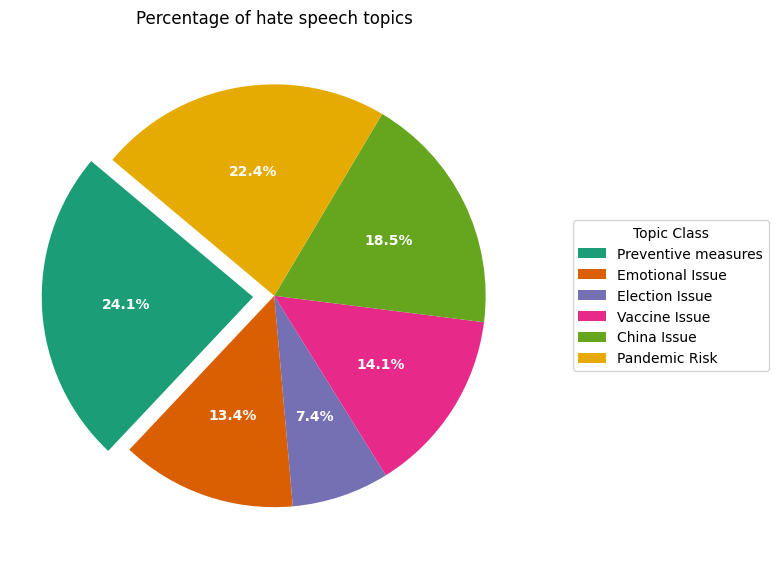

In [169]:
import matplotlib.pyplot as plt

# Prepare Data
df = text_data.groupby('topic').size().reset_index(name='counts')

# Draw Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 100)

data = df['counts']
categories = ["Preventive measures", 'Emotional Issue', 'Election Issue', 'Vaccine Issue', 'China Issue', 'Pandemic Risk']#df['topic']
explode = [0.1,0,0,0,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    # return "{:.1f}% ({:d} )".format(pct, absolute)
    return "{:.1f}%".format(pct)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)

# Decoration
ax.legend(wedges, categories, title="Topic Class", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Percentage of hate speech topics")
# plt.show()
plt.savefig('/content/gdrive/MyDrive/Colab/COMS6998EMODS/topic.jpg')

In [66]:
TOPIC = {'1':["people", "time", "good", "flu", "thing", "call", "today", "month", "start", "coming", "ive", "thought", "die", "long", "best"],
'2':["coronavirus", "covid", "coronavirusupdate", "corona", "well", "coronavirusoutbreak", "coronavirusuk", "coronavid", "coronavirususa", "coviduk", "officially", "cornoravirusuk", "coronaoutbreak", "coronavirusupdates", "pandemia"],
'3':["coronavirus", "trump", "going", "cant", "realdonaldtrump", "panic", "american", "toilet", "paper", "president", "real", "medium", "house", "america", "word"],
'4':["coronavirus", "event", "cancelled", "march", "game", "cancel", "concern", "fan", "conference", "big", "canceled", "meeting", "decision", " postponed", "going"],
'5':["coronavirus", "case", "health", "italy", "death", "confirmed", "country", "state", "emergency", "number", "breaking", "update", "positive", " total", "tested"],
'6':["coronavirus", "help", "news", "read", "live", "great", "watch", "question", "situation", "community", "expert", "latest", "free", "public", "advice"],
'7':["coronavirus", "china", "spread", "outbreak", "virus", "wuhan", "travl", "ncov", "quarantine", "chinese", "flight", "international", "iran", "city", "novel"],
'8':["pandemic", "coronavirus", "test", "testing", "disease", "hospital", "doctor", "cdc", "patient", "system", "spread", "healthcare", "vaccine", "classifies", "action"],
'9':["coronavirus", "work", "business", "sick", "government", "crisis", "plan", "online", "student", "impact", "market", "budget", "economy", "class", "employee"],
'10':["coronavirus", "day", "school", "week", "close", "spreading", "fast", "social", "nation", "shut", "hour", "kid", "ago", "open", "area"],
'11':["coronavirus", "hand", "virus", "dont", "stay", "keep", "corona", "wash", "safe", "mask", "face", "hope", "avoid", "kill", "worried"],
'12':["coronavirus", "life", "year", "care", "risk", "better", "symptom", "lot", "family", "told", "serious", "bad", "sure", "contact", "making"]}

In [68]:

def preprocess(text):
    text = preprocess_tweet(text)
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

topic_index = []

for index, row in data.iterrows():
  text = row['full_text']
  text_word = preprocess(text)
  topic_score = []

  for key, value in TOPIC.items():
    cnt = 0
    for v in value:
      cnt += text_word.count(v)
    topic_score.append(cnt)
  max_cnt = max(topic_score)
  topic = topic_score.index(max_cnt) + 1
  print(topic, max_cnt)





11 1
1 0
2 1
11 1
1 0
3 2
2 1
2 1
2 1
6 1
3 3
3 3
2 1
2 1
1 1
6 3
2 1
1 0
2 1
2 1
8 3
1 0
2 1
1 1
1 0
1 0
1 0
9 2
2 1
3 5
5 6
2 1
2 1
1 0
1 0
1 1
1 1
1 1
1 1
11 2
2 1
11 3
2 1
1 1
2 1
1 1
2 1
2 1
9 2
1 0
3 3
1 0
3 1
3 2
3 3
3 3
3 3
3 3
3 3
2 2
1 2
2 2
2 1
1 2
2 1
1 0
10 2
1 0
7 2
10 1
2 1
3 2
3 2
2 1
9 2
11 2
2 1
1 1
2 1
1 0
1 2
1 0
2 1
2 2
8 3
9 2
9 2
3 3
1 0
1 2
2 1
1 2
1 1
1 2
6 2
8 3
12 1
12 3
6 2
6 2
1 0
6 2
1 1
2 1
11 2
1 1
2 1
7 2
3 3
2 1
1 1
1 1
11 2
9 2
3 3
3 2
2 1
5 1
1 0
3 2
3 1
6 2
1 0
1 0
2 1
1 0
2 1
3 2
1 1
2 1
2 1
2 1
2 2
2 1
1 1
11 2
1 0
6 1
1 0
1 0
10 1
5 1
2 1
1 0
1 0
3 1
1 0
6 1
2 1
8 1
1 1
2 1
2 1
1 0
9 2
1 0
3 1
1 1
1 0
1 0
3 2
1 1
1 1
10 1
7 3
1 0
7 2
2 1
2 2
1 0
3 1
11 1
1 1
3 2
3 2
3 2
6 1
1 1
1 0
2 1
2 1
12 3
2 1
2 2
1 1
1 0
3 2
1 0
1 1
1 1
3 2
1 0
1 0
10 2
1 0
1 0
3 2
10 2
2 1
4 2
7 1
1 1
3 2
7 2
8 2
8 2
2 1
2 1
8 2
9 1
8 2
6 2
1 0
5 1
8 2
11 2
1 2
2 1
3 1
1 0
10 1
1 0
7 2
1 0
1 3
6 1
1 0
9 3
2 1
7 1
2 1
2 1
3 1
1 2
2 1
1 1
3 4
3 2
1 0
1 0
2 1
6 1
2 1
11 2
2 1

KeyboardInterrupt: ignored